# Introduction
TRPO is very successful in many scenarios, yet its costly computation makes it expensive. PPO is proposed to solve this drawback in 2017. Based on TRPO, PPO is simplier, proved by many experiments that learns as good as, or even better than TRPO, which makes PPO prevailing. 

Nowadays if we want to try RL in a new environment, PPO is a first choice we can take. 

Recall that the objective of TRPO: $$\max_\theta \mathbb{E}_{s \sim \nu^{\pi_{\theta_k}}} \mathbb{E}_{a \sim \pi_{\theta_k}(\cdot|s)} [\frac{\pi(a|s)}{\pi_k(a|s)}A_{\pi_k}(s, a)] \\ \text{s.t.} \mathbb{E}_{s \sim \nu^{\pi_{\theta_k}}}[D_{KL}(\pi_k(\cdot|s)||\pi(\cdot|s))] \leq \delta$$

TRPO use KKT conditions, Lagrangian multipliers, Taylor Expansion Approximation, Conjugate Gradient, Linear Search, etc. to solve the problem directly. 

PPO has the same objective, but it takes a simpler way for solution. To be specific, there are 2 forms of PPO: PPO-penalty and PPO-clip.

## PPO penalty

PPO penalty adopts Lagrange multiplier to take the KL constraints into the objective:
$$\arg \max_\theta \mathbb{E}_{s \sim \nu^{\pi_{\theta_k}}} \mathbb{E}_{a \sim \pi_{\theta_k}(\cdot|s)} [\frac{\pi_\theta(a|s)}{\pi_{\theta_k}(a|s)} A^{\pi_{\theta_k}} - \beta D_{KL}[\pi_{\theta_k}(\cdot|s) || \pi_\theta (\cdot|s)]]$$

This makes the optimization unconstrainted, where $\beta$ is a coefficient being updated during training. Let $d_k = D_{KL}^{\nu^{\pi_{\theta_k}}}(\pi_{\theta_k}, \pi_\theta)$. 

The rule for updating is:
- if $d_k < \delta/1.5$, $\beta_{k+1} = \beta_k/2$
- else if $d_k > \delta*1.5$, $\beta_{k+1} = \beta_k*2$
- else $\beta_{k+1} = \beta_k$.

$\delta$ is a pre-defined hyperparameter to constrain the policy updates. 

## PPO clip
PPO clip is more direct. In rid of KL divergence, it constrains the coefficient of update such that the update won't take too much, namely

$$\arg \max_\theta \mathbb{E}_{s \sim \nu^{\pi_{\theta_k}}} \mathbb{E}_{a \sim \pi_{\theta_k}} [\min (\frac{\pi_{\theta}(a|s)}{\pi_{\theta_k}(a|s)} A^{\pi_{\theta_k}}(s, a), \text{clip}(\frac{\pi_\theta(a|s)}{\pi_{\theta_k}(a|s)}, 1-\epsilon, 1+\epsilon)A^{\pi_{\theta_k}}(s, a))],$$

among which $\text{clip}(x, r ,l) = \max(\min(x, r), l)$ limits $x$ inside $[l, r]$. 

Huge amount of experiments shows that PPO-clip always does better than PPO-penalty. Hence, in this chapter we only apply for PPO-clip.

In [1]:
import gym
import numpy as np
np.bool8 = np.bool_
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [76]:
class PPO:
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state):
        # TODO: implement take_action, sample from policy \pi(a|s)
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.detach().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        terminated = torch.tensor(transition_dict['terminated'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        truncated = torch.tensor(transition_dict['truncated'],
                        dtype=torch.float).view(-1, 1).to(self.device)
        
        # TODO: implement update method

        # compute values for critic update
        v_old = self.critic(states)
        v_new = self.critic(next_states)
        td_est = rewards + self.gamma * v_new * (1 - terminated) * (1 - truncated)
        


        # compute advantage and probs for actor update
        td_error = td_est - v_old
        advantages = rl_utils.compute_advantage(self.gamma, self.lmbda, td_error)
        # normalize advantage for stable training
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()
        
        # update for given epochs
        for i in range(self.epochs):
            new_log_probs = torch.log(self.actor(states).gather(1, actions))
            prob_ratio = torch.exp(new_log_probs - old_log_probs)
            clip_res = torch.clamp(prob_ratio, 1 - self.eps, 1 + self.eps)

            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_est.detach()))
            self.critic_optimizer.zero_grad()
            critic_loss.backward(retain_graph=True)
            self.critic_optimizer.step()

            actor_loss = - torch.mean(torch.min(prob_ratio * advantages, clip_res * advantages))

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

In [77]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
# env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 60.19it/s, episode=500, return=194.500]


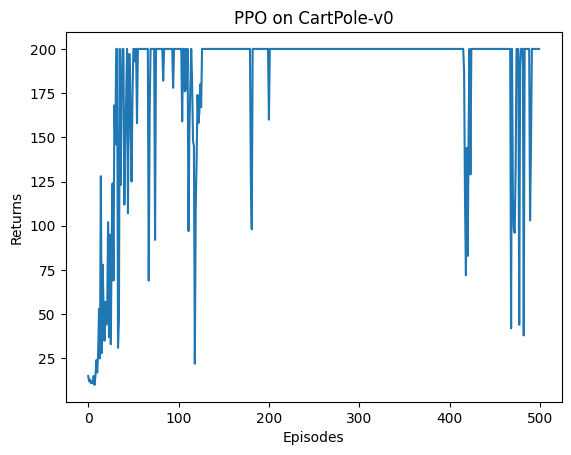

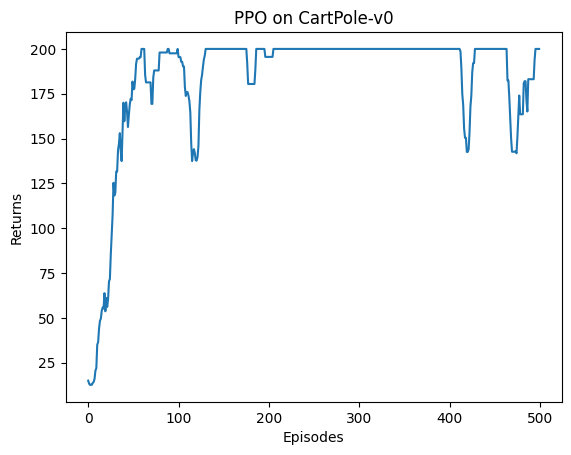

In [78]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

In [79]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))
        return mu, std

In [86]:
class PPOContinuous:
    ''' 处理连续动作的PPO算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,
                                         action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def take_action(self, state):
        # TODO: implement take_action
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, std = self.actor(state)
        action_dist = torch.distributions.Normal(mu, std)
        action = action_dist.sample()
        return [action.item()]

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        terminated = torch.tensor(transition_dict['terminated'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        truncated = torch.tensor(transition_dict['truncated'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        
        rewards = (rewards + 8.0) / 8.0
        # TODO: complete the update method

        # calculate td est
        td_est = rewards + self.gamma * self.critic(next_states) * (1 - terminated) * (1 - truncated)
        td_error = td_est - self.critic(states)
        advantages = rl_utils.compute_advantage(self.gamma, self.lmbda, td_error.detach())

        # calculate log probs
        mu, std = self.actor(states)
        old_log_dist = torch.distributions.Normal(mu, std)
        old_log_prob = old_log_dist.log_prob(actions).detach()

        for i in range(self.epochs):
            mu, std = self.actor(states)
            new_log_dist = torch.distributions.Normal(mu, std)
            new_log_prob = new_log_dist.log_prob(actions)
            prob_ratio = torch.exp(new_log_prob - old_log_prob)
            clip_ratio = torch.clamp(prob_ratio, 1 - self.eps, 1 + self.eps)

            actor_loss = -torch.mean(torch.min(prob_ratio * advantages, clip_ratio * advantages))
            critic_loss = F.mse_loss(self.critic(states), td_est.detach())

            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [87]:
actor_lr = 1e-4
critic_lr = 5e-3
num_episodes = 2000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
# env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]  # 连续动作空间
agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|██████████| 200/200 [00:03<00:00, 58.52it/s, episode=2000, return=-229.944]


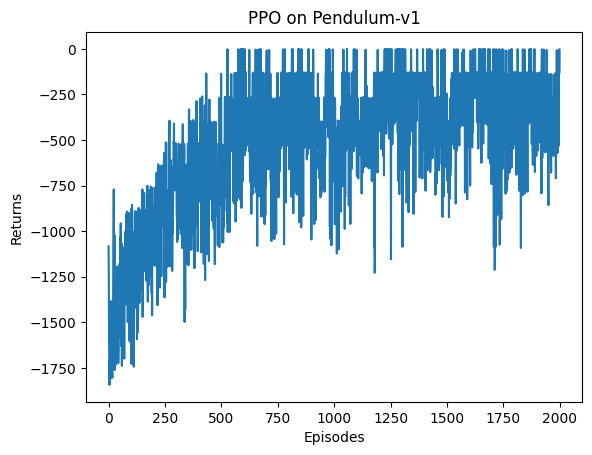

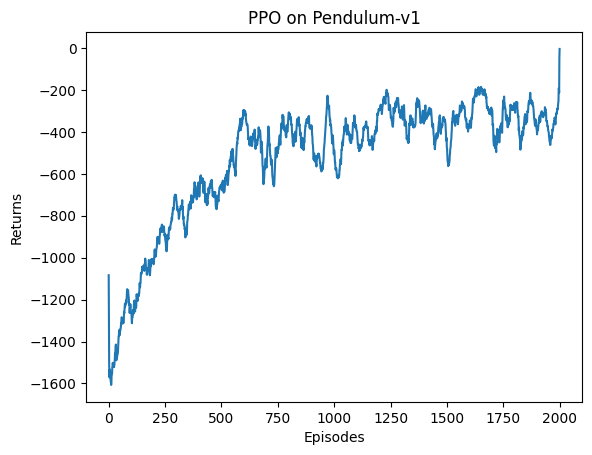

In [88]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 21)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

# Conclusion
PPO is a simplified version of TRPO which gives better performances in many scenarios, making it a baseline method in many RL problems. It is worth noticing that TRPO and PPO are both online on-policy methods.